# CIFAR-100 Classification with a Custom CNN

### Overview

This notebook demonstrates how to build, train, and evaluate a custom Convolutional Neural Network (CNN) for classifying images from the CIFAR-100 dataset. It covers data preprocessing, model architecture design, training with various optimization techniques, and evaluation of performance. The main outcome is a working CNN model that achieves competitive accuracy on CIFAR-100, along with insights into effective deep learning strategies for image classification.




### Setting up the Environment

In [ ]:
!pip install torchinfo
!pip install torch
!pip install tensorflow
!pip install torchvision
!pip install matplotlib
!pip install numpy

### Import dependencies

In [2]:
import torch
import tensorflow as tf
import torchinfo
import torch.nn as nn
import torch.nn.functional as F
from torchinfo import summary
import torchvision
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
import numpy as np
import torch.optim as optim
import torchvision.datasets as datasets
from torch.utils.data import DataLoader

### Data Augmentation and Loading

In [ ]:
import torchvision.transforms as transforms
import torchvision

transform_train = transforms.Compose([
    transforms.RandomCrop(32, padding=4),  # Slightly shift images
    transforms.RandomHorizontalFlip(),  # Flip image with 50% probability
    transforms.RandomRotation(15),  # Rotate image up to ±15 degrees
    transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.1),  # Adjust colors randomly
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)),  # Normalize
    transforms.RandomErasing(p=0.5, scale=(0.02, 0.2), ratio=(0.3, 3.3))  # Cutout (Regularization)
])

transform_test = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])

# Load CIFAR-100 dataset
trainset = torchvision.datasets.CIFAR100(root='./data', train=True, download=True, transform=transform_train)
testset = torchvision.datasets.CIFAR100(root='./data', train=False, download=True, transform=transform_test)

# Create DataLoaders
trainloader = torch.utils.data.DataLoader(trainset, batch_size=128, shuffle=True, num_workers=2)
testloader = torch.utils.data.DataLoader(testset, batch_size=128, shuffle=False, num_workers=2)

trainloader = DataLoader(trainset, batch_size=64, shuffle=True, num_workers=2)
testloader = DataLoader(testset, batch_size=64, shuffle=False, num_workers=2)

### Designing the CNN model

In [4]:
import torch
import torch.nn as nn
import torch.nn.functional as F

class CIFAR100ConvNet(nn.Module):
    def __init__(self):
        super(CIFAR100ConvNet, self).__init__()

        self.conv1 = nn.Sequential(
            nn.Conv2d(3, 32, 3, padding=1),
            nn.BatchNorm2d(32),
            nn.ReLU()
        )

        self.conv2 = nn.Sequential(
            nn.Conv2d(32, 32, 3, padding=1),
            nn.BatchNorm2d(32),
            nn.ReLU(),
            nn.MaxPool2d(2)  # 32x32 → 16x16
        )

        self.conv3 = nn.Sequential(
            nn.Conv2d(32, 64, 3, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU()
        )

        self.conv4 = nn.Sequential(
            nn.Conv2d(64, 64, 3, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.MaxPool2d(2)  # 16x16 → 8x8
        )

        self.conv5 = nn.Sequential(
            nn.Conv2d(64, 128, 3, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU()
        )

        self.conv6 = nn.Sequential(
            nn.Conv2d(128, 128, 3, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(),
            nn.MaxPool2d(2)  # 8x8 → 4x4
        )

        self.conv7 = nn.Sequential(
            nn.Conv2d(128, 256, 3, padding=1),
            nn.BatchNorm2d(256),
            nn.ReLU()
        )

        self.conv8 = nn.Sequential(
            nn.Conv2d(256, 256, 3, padding=1),
            nn.BatchNorm2d(256),
            nn.ReLU(),
            nn.MaxPool2d(2)  # 4x4 → 2x2
        )

        self.conv9 = nn.Sequential(
            nn.Conv2d(256, 512, 3, padding=1),
            nn.BatchNorm2d(512),
            nn.ReLU()
        )

        self.conv10 = nn.Sequential(
            nn.Conv2d(512, 512, 3, padding=1),
            nn.BatchNorm2d(512),
            nn.ReLU()
        )

        # Global Average Pooling (GAP) for better generalization
        self.global_avg_pool = nn.AdaptiveAvgPool2d(1)

        # Fully connected layers
        self.fc1 = nn.Linear(512, 512)  # Changed to match GAP output
        self.dropout = nn.Dropout(0.5)
        self.fc2 = nn.Linear(512, 100)  # 100 classes

    def forward(self, x):
        x = self.conv1(x)
        x = self.conv2(x)
        x = self.conv3(x)
        x = self.conv4(x)
        x = self.conv5(x)
        x = self.conv6(x)
        x = self.conv7(x)
        x = self.conv8(x)
        x = self.conv9(x)
        x = self.conv10(x)

        x = self.global_avg_pool(x)  # Replaces Flatten
        x = torch.flatten(x, start_dim=1)
        x = self.fc1(x)
        x = F.relu(x)
        x = self.dropout(x)
        x = self.fc2(x)
        return F.log_softmax(x, dim=1)


#### Moving to Cuda if available or else it will run on CPU

In [5]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = CIFAR100ConvNet().to(device)


#### Defining the optimizers and schedulers

In [6]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=0.01, momentum=0.9, weight_decay=5e-4)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=30, gamma=0.1)


### Training the Model

In [ ]:
num_epochs = 100  # Increased from 10 to 100

best_acc = 0.0  # Store the best validation accuracy

for epoch in range(num_epochs):
    model.train()  # Set model to training mode
    running_loss = 0.0
    correct = 0
    total = 0

    # Training Loop
    for images, labels in trainloader:
        images, labels = images.to(device), labels.to(device)

        optimizer.zero_grad()  # Clear gradients
        outputs = model(images)  # Forward pass
        loss = criterion(outputs, labels)  # Compute loss
        loss.backward()  # Backpropagation
        optimizer.step()  # Update weights

        running_loss += loss.item()

        # Compute training accuracy
        _, predicted = torch.max(outputs, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

    train_acc = 100 * correct / total  # Calculate train accuracy

    # Validation Loop
    model.eval()  # Set model to evaluation mode
    val_loss = 0.0
    correct = 0
    total = 0

    with torch.no_grad():  # No need to calculate gradients
        for images, labels in testloader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            loss = criterion(outputs, labels)
            val_loss += loss.item()

            # Compute validation accuracy
            _, predicted = torch.max(outputs, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    val_acc = 100 * correct / total  # Calculate validation accuracy

    # Learning rate scheduler step
    scheduler.step()

    # Save the best model
    if val_acc > best_acc:
        best_acc = val_acc
        torch.save(model.state_dict(), "best_model.pth")  # Save best model

    # Print training and validation metrics
    print(f"Epoch [{epoch+1}/{num_epochs}] | "
          f"Train Loss: {running_loss/len(trainloader):.4f} | "
          f"Train Acc: {train_acc:.2f}% | "
          f"Val Loss: {val_loss/len(testloader):.4f} | "
          f"Val Acc: {val_acc:.2f}%")

print(f"Training complete! Best validation accuracy: {best_acc:.2f}%")

Epoch [1/100] | Train Loss: 4.0523 | Train Acc: 6.99% | Val Loss: 3.6135 | Val Acc: 12.96%
Epoch [2/100] | Train Loss: 3.6001 | Train Acc: 13.71% | Val Loss: 3.1414 | Val Acc: 21.01%
Epoch [3/100] | Train Loss: 3.3053 | Train Acc: 18.49% | Val Loss: 2.7968 | Val Acc: 28.19%
Epoch [4/100] | Train Loss: 3.0495 | Train Acc: 22.93% | Val Loss: 2.6767 | Val Acc: 30.46%
Epoch [5/100] | Train Loss: 2.8681 | Train Acc: 26.94% | Val Loss: 2.4357 | Val Acc: 35.32%
Epoch [6/100] | Train Loss: 2.7169 | Train Acc: 29.85% | Val Loss: 2.3835 | Val Acc: 35.92%
Epoch [7/100] | Train Loss: 2.5973 | Train Acc: 32.40% | Val Loss: 2.2410 | Val Acc: 39.62%
Epoch [8/100] | Train Loss: 2.4806 | Train Acc: 35.02% | Val Loss: 2.2139 | Val Acc: 40.67%
Epoch [9/100] | Train Loss: 2.4079 | Train Acc: 36.86% | Val Loss: 2.1209 | Val Acc: 43.04%
Epoch [10/100] | Train Loss: 2.3227 | Train Acc: 38.54% | Val Loss: 2.0079 | Val Acc: 45.26%
Epoch [11/100] | Train Loss: 2.2581 | Train Acc: 40.18% | Val Loss: 2.0380 | Val

#### Checking if the checkpoint exists.

In [7]:
import torch

model_path = "best_model.pth"

try:
    checkpoint = torch.load(model_path)  # Try loading the file
    print("Checkpoint loaded successfully!")
except Exception as e:
    print("Error loading checkpoint:", e)


Checkpoint loaded successfully!


#### Loading the Checkpoint for further training

In [10]:
import torch

# Load the checkpoint before resuming training
checkpoint_path = "best_model.pth"
model.load_state_dict(torch.load(checkpoint_path))

# Set model to training mode
model.train()

# Define the starting epoch and best validation accuracy
start_epoch = 94  # Resume from epoch 94
best_acc = 66.68  # Update with the best recorded accuracy

#### Training to complete the 100 epochs

In [11]:
num_epochs = 100  # Total epochs

for epoch in range(start_epoch, num_epochs):  # Resume from epoch 94
    model.train()  # Set model to training mode
    running_loss = 0.0
    correct = 0
    total = 0

    # Training Loop
    for images, labels in trainloader:
        images, labels = images.to(device), labels.to(device)

        optimizer.zero_grad()  # Clear gradients
        outputs = model(images)  # Forward pass
        loss = criterion(outputs, labels)  # Compute loss
        loss.backward()  # Backpropagation
        optimizer.step()  # Update weights

        running_loss += loss.item()

        # Compute training accuracy
        _, predicted = torch.max(outputs, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

    train_acc = 100 * correct / total  # Calculate train accuracy

    # Validation Loop
    model.eval()  # Set model to evaluation mode
    val_loss = 0.0
    correct = 0
    total = 0

    with torch.no_grad():  # No need to calculate gradients
        for images, labels in testloader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            loss = criterion(outputs, labels)
            val_loss += loss.item()

            # Compute validation accuracy
            _, predicted = torch.max(outputs, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    val_acc = 100 * correct / total  # Calculate validation accuracy

    # Learning rate scheduler step
    scheduler.step()

    # Save the best model
    if val_acc > best_acc:
        best_acc = val_acc
        torch.save(model.state_dict(), "best_model.pth")  # Save best model
        print(f"Checkpoint Saved! New Best Val Acc: {best_acc:.2f}%")

    # Print training and validation metrics
    print(f"Epoch [{epoch+1}/{num_epochs}] | "
          f"Train Loss: {running_loss/len(trainloader):.4f} | "
          f"Train Acc: {train_acc:.2f}% | "
          f"Val Loss: {val_loss/len(testloader):.4f} | "
          f"Val Acc: {val_acc:.2f}%")

print(f"Training Resumed and Completed! Best validation accuracy: {best_acc:.2f}%")


Epoch [95/100] | Train Loss: 1.7004 | Train Acc: 53.75% | Val Loss: 1.6917 | Val Acc: 53.72%
Epoch [96/100] | Train Loss: 1.6767 | Train Acc: 54.08% | Val Loss: 1.5306 | Val Acc: 57.82%
Epoch [97/100] | Train Loss: 1.6356 | Train Acc: 55.34% | Val Loss: 1.5980 | Val Acc: 56.03%
Epoch [98/100] | Train Loss: 1.6185 | Train Acc: 55.71% | Val Loss: 1.5582 | Val Acc: 57.01%
Epoch [99/100] | Train Loss: 1.6017 | Train Acc: 56.06% | Val Loss: 1.5526 | Val Acc: 57.55%
Epoch [100/100] | Train Loss: 1.5812 | Train Acc: 56.52% | Val Loss: 1.5144 | Val Acc: 58.68%
Training Resumed and Completed! Best validation accuracy: 66.68%


#### Loading the best model and Switching to Evaluation mode

In [12]:
model.load_state_dict(torch.load("best_model.pth"))
model.to(device)
model.eval()

CIFAR100ConvNet(
  (conv1): Sequential(
    (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
  )
  (conv2): Sequential(
    (0): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (conv3): Sequential(
    (0): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
  )
  (conv4): Sequential(
    (0): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode

### Evaluating and Visualising the Model 

In [13]:
all_labels = []
all_predictions = []

with torch.no_grad():  # Disable gradient calculation
    for images, labels in testloader:
        images, labels = images.to(device), labels.to(device)
        outputs = model(images)

        # Get predicted class
        _, predicted = torch.max(outputs, 1)

        # Store predictions and true labels
        all_labels.extend(labels.cpu().numpy())
        all_predictions.extend(predicted.cpu().numpy())

#### Creating the Classification Report

In [14]:
from sklearn.metrics import confusion_matrix, classification_report, f1_score, recall_score, accuracy_score

cm = confusion_matrix(all_labels, all_predictions)
cr = classification_report(all_labels, all_predictions)
fs = f1_score(all_labels, all_predictions, average='weighted')
rs = recall_score(all_labels, all_predictions, average='weighted')
accuracy = accuracy_score(all_labels, all_predictions)

# Print results
print('Confusion Matrix:')
print(cm)
print('Classification Report:')
print(cr)
print(f'F1 Score: {fs:.4f}')
print(f'Recall Score: {rs:.4f}')
print(f'Accuracy Score: {accuracy:.4f}')

Confusion Matrix:
[[88  0  1 ...  0  0  0]
 [ 0 84  0 ...  0  0  0]
 [ 0  2 56 ...  0  4  0]
 ...
 [ 0  0  0 ... 68  0  0]
 [ 0  0  3 ...  0 46  0]
 [ 0  0  1 ...  0  0 68]]
Classification Report:
              precision    recall  f1-score   support

           0       0.80      0.88      0.84       100
           1       0.81      0.84      0.82       100
           2       0.52      0.56      0.54       100
           3       0.48      0.46      0.47       100
           4       0.41      0.48      0.44       100
           5       0.64      0.74      0.69       100
           6       0.61      0.76      0.68       100
           7       0.72      0.64      0.68       100
           8       0.87      0.80      0.83       100
           9       0.74      0.81      0.78       100
          10       0.58      0.55      0.56       100
          11       0.47      0.42      0.44       100
          12       0.74      0.80      0.77       100
          13       0.61      0.61      0.61   

#### Visualising the Confusion Matrix 

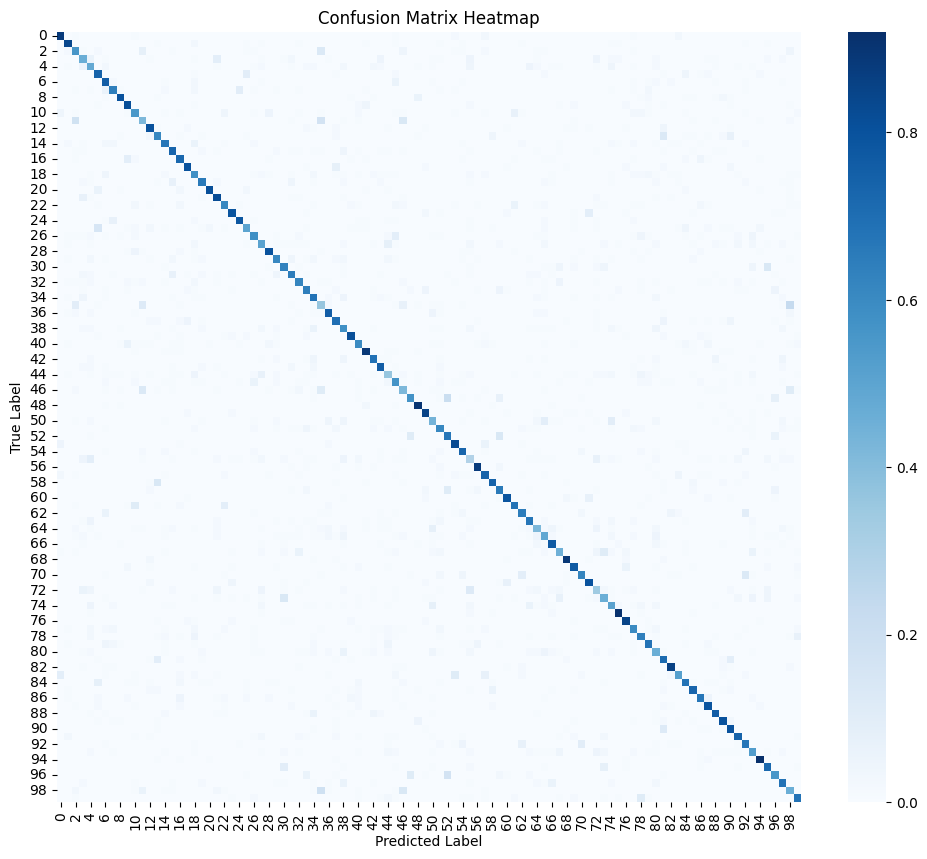

In [15]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from sklearn.metrics import confusion_matrix

# Assuming y_test contains the true labels and y_pred contains the predicted labels
cm = confusion_matrix(all_labels, all_predictions)

# Normalize the confusion matrix for better visualization
cm_normalized = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

# Plot the heatmap
plt.figure(figsize=(12, 10))
sns.heatmap(cm_normalized, annot=False, cmap="Blues", fmt=".2f")

plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Confusion Matrix Heatmap")
plt.show()


#### Identifying the Top 10 Misclassified Labels

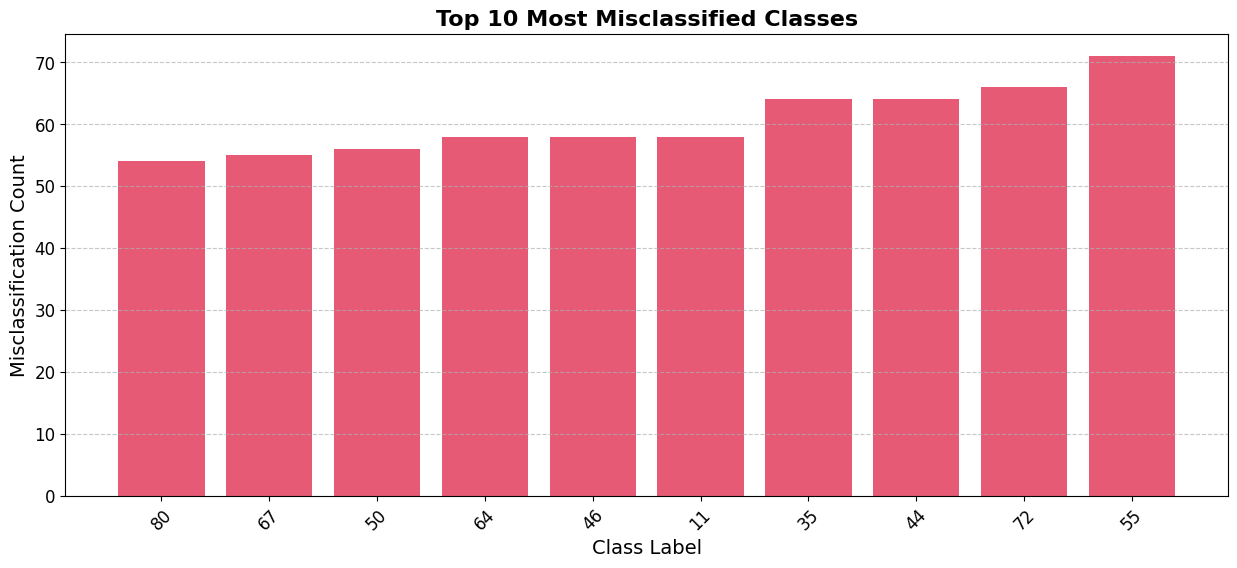

In [16]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix, classification_report, f1_score, recall_score, accuracy_score

# Compute metrics
cm = confusion_matrix(all_labels, all_predictions)
cr = classification_report(all_labels, all_predictions, output_dict=True)
fs = f1_score(all_labels, all_predictions, average='weighted')
rs = recall_score(all_labels, all_predictions, average='weighted')
accuracy = accuracy_score(all_labels, all_predictions)

# Normalize confusion matrix
cm_normalized = cm.astype('float') / cm.sum(axis=1, keepdims=True)

# Extract class-wise recall
class_recalls = {str(k): v["recall"] for k, v in cr.items() if k.isdigit()}

# ---- Identify Most Misclassified Classes ----
misclassified_counts = np.sum(cm, axis=1) - np.diag(cm)
top_misclassified = np.argsort(misclassified_counts)[-10:]  # Get top 10 misclassified classes

plt.figure(figsize=(15, 6))
plt.bar(range(len(top_misclassified)), misclassified_counts[top_misclassified], color='crimson', alpha=0.7)
plt.xlabel('Class Label', fontsize=14)
plt.ylabel('Misclassification Count', fontsize=14)
plt.title('Top 10 Most Misclassified Classes', fontsize=16, fontweight='bold')
plt.xticks(range(len(top_misclassified)), top_misclassified, fontsize=12, rotation=45)
plt.yticks(fontsize=12)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()



#### Visualising the Misclassified Images

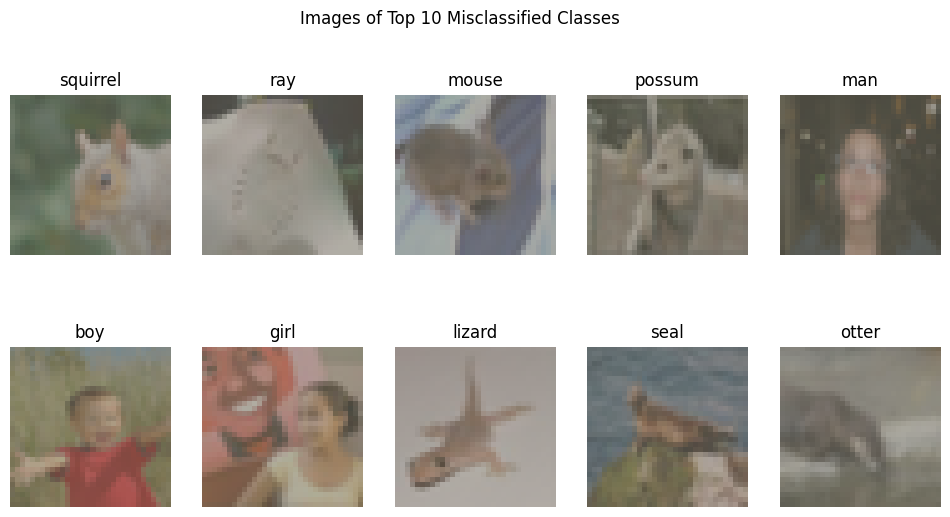

In [17]:
class_labels = trainset.classes  # List of 100 class names

# Function to denormalize images
def denormalize(img):
    mean = np.array([0.4914, 0.4822, 0.4465])
    std = np.array([0.2023, 0.1994, 0.2010])
    img = img * std.reshape((1, 1, 3)) + mean.reshape((1, 1, 3))
    return np.clip(img, 0, 1)

# Visualizing top misclassified class images
fig, axes = plt.subplots(2, 5, figsize=(12, 6))
axes = axes.flatten()

for idx, class_idx in enumerate(top_misclassified):
    # Find an image from the misclassified class
    indices = [i for i, label in enumerate(testset.targets) if label == class_idx]
    image, _ = testset[indices[0]]  # Pick the first occurrence
    image = image.permute(1, 2, 0).numpy()  # Convert to numpy
    image = denormalize(image)  # Denormalize

    # Plot the image
    axes[idx].imshow(image)
    axes[idx].set_title(class_labels[class_idx])
    axes[idx].axis("off")

plt.suptitle("Images of Top 10 Misclassified Classes")
plt.show()

